# Mediation-Agreements Data Explorer



In [1]:
__author__      = 'Roy Gardner'

%run ./mediation_functions.py


## Load the mediation-actor data

- Load data into a biadjacency matrix with mediations in rows and actors in columns
- Matrix values are zero except where a relation between a mediation and an actor exists where the value is an non-zero integer that codes the mediation-actor edge properties.
- Apart from the matrix other data are extracted or computed.
- All data are stored in data_dict




In [2]:

data_path = './data/'
mediation_file = 'mediation.csv'
actors_file = 'actors.csv'

data_dict = load_mediation_data(mediation_file,actors_file,data_path)

print(data_dict['header'])


['year', 'mediation ID', 'negotiation ID', 'conflict locale', 'conflict sub-locale', 'locale Gleditsch ID', 'third-party', 'third-party Gleditsch ID', 'location of neogitations', 'negotiation location Gleditsch ID', 'negotiation type', 'leading actor', 'leading actor 2', 'leading actor 3', 'good offices', 'mediation', 'hosting talks', 'negotiating and drafting', 'manipulating', 'humanitarian', 'witness/party to agreement', 'other', 'agreement', 'peace agreement', 'ceasfire agreement', 'agreement name', 'notes_1', 'source_1', 'note_2', 'source_2', 'note_3', 'source_3', 'note_4', 'source_4', 'note_5', 'source_5', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9', '']


## Extract sub-matrix for mediations that result in agreement

(57, 46)


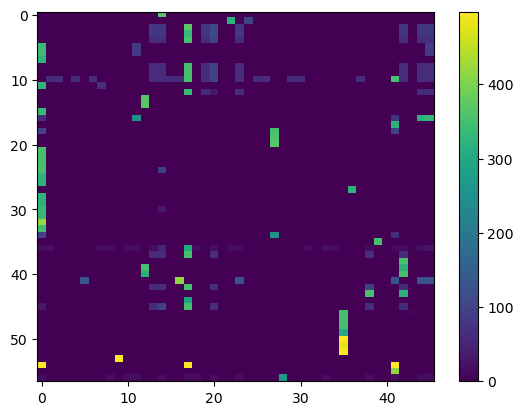

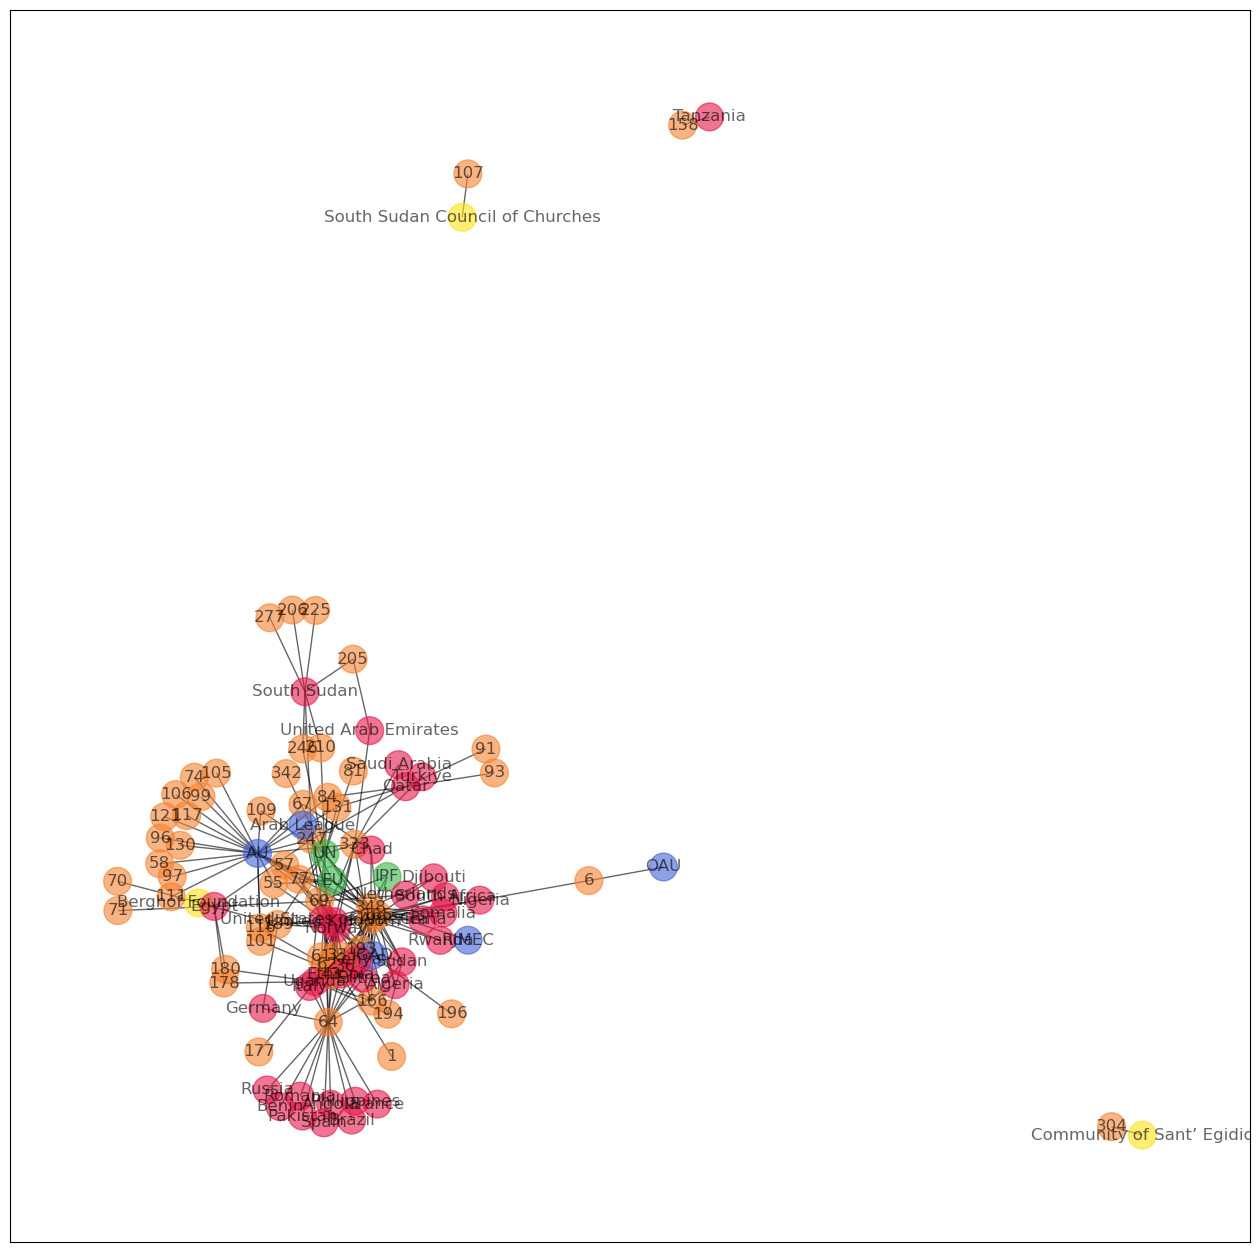

In [3]:
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
# Get mediation vertices

peace_mediation_ids = [k for k,v in data_dict['vertices_dict'].items() if v['type'] == 'MED' and\
                  v['data']['peace_agreement'] == 1]


peace_mediation_indices = [data_dict['mediation_vertices'].index(v) for v in peace_mediation_ids]


peace_matrix = data_dict['matrix'][np.ix_(peace_mediation_indices,range(0,len(data_dict['actor_vertices'])))]

# Get columns containing non-zero value
indices = np.where(peace_matrix > 0)
peace_actor_indices = list(set(indices[1]))

peace_matrix = peace_matrix[np.ix_(range(0,peace_matrix.shape[0]),peace_actor_indices)]
print(peace_matrix.shape)

peace_actor_ids = [data_dict['actor_vertices'][index] for index in peace_actor_indices]


peace_dict = {}
peace_dict['matrix'] = peace_matrix
peace_dict['mediation_vertices'] = peace_mediation_ids
peace_dict['actor_vertices'] = peace_actor_ids

plt.imshow(peace_matrix,aspect='auto')
plt.colorbar()
plt.show()

adjacency_matrix,adj_vertices = adjacency_from_biadjacency(peace_dict)
bin_matrix = (adjacency_matrix > 0).astype(np.int8)


node_labels = {i:v for i,v in enumerate(adj_vertices)}
node_colors = [data_dict['color_map'][data_dict['vertices_dict']\
                                      [vertex_id]['type']] for vertex_id in adj_vertices]

graph = nx.from_numpy_array(bin_matrix, create_using=nx.Graph)
f = plt.figure(figsize=(16,16))
pos = nx.spring_layout(graph) 
nx.draw_networkx(graph,pos,labels=node_labels,node_color=node_colors,\
                 node_size=400,font_size=12,alpha=0.6)
plt.grid(False)
plt.show()


## Not all actors engage in mediations that result in an agreement

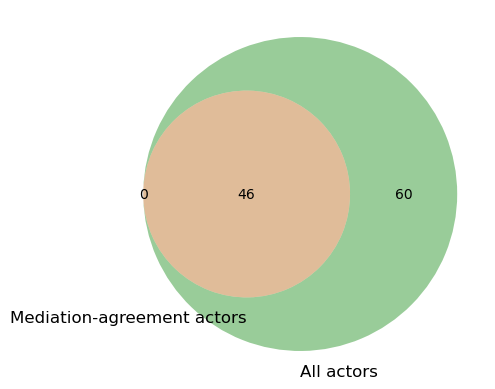

{'Croatia', 'PAX', 'Gabon', 'The Peaceful Co-Existence Committee', 'Shilluk reth', 'Denmark', 'Finland', 'Togo', 'African Development Bank', 'Ghana', 'Slovenia', 'Abel Alier', 'Libya', 'Liberia', 'The Republic of Korea', 'Christian Relief', 'Abyei businessmen', 'Belgium', 'Islamic Development Bank', 'Fashoda Relief', 'Malta', 'Portugal', 'Hungary', 'Japan', 'Zimbabwe', 'South Sudanese religious leaders', 'Sweden', 'Local Murle elites', 'Morocco', 'James Ellery', 'Canada', 'Ireland', 'Czechia', 'Norwegian Church Aid', 'World Bank', 'Burundi', 'CTSAMVM', 'Equatorian Church Leaders', 'ICRC', 'IMF', 'Carter Center', 'National Democratic Institute', 'Lesotho', 'Switzerland', 'Darfur Security Committee', 'Estonia', 'Episcopal Church of Sudan', 'Greece', 'Arab Fund for Social Development', 'ACCORD', 'Equatorial Guinea', 'NGO consortium', 'Kuwait', 'The Native Administration', 'Lithuania', 'South Sudanese Church Leaders', 'Poland', 'African Diplomatic Corps', 'ICC', 'Sierra Leone'}


In [4]:
venn2([set(peace_actor_ids),set(data_dict['actor_vertices'])],['Mediation-agreement actors','All actors'])
plt.show()

print(set(data_dict['actor_vertices']).difference(set(peace_actor_ids)))


## Lead actor analysis

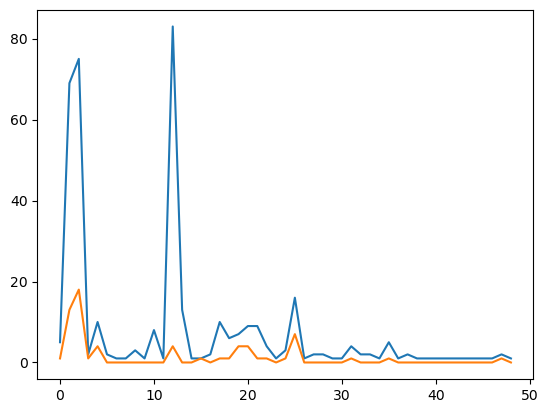

PearsonRResult(statistic=0.8186024477084947, pvalue=6.72854176702811e-13)


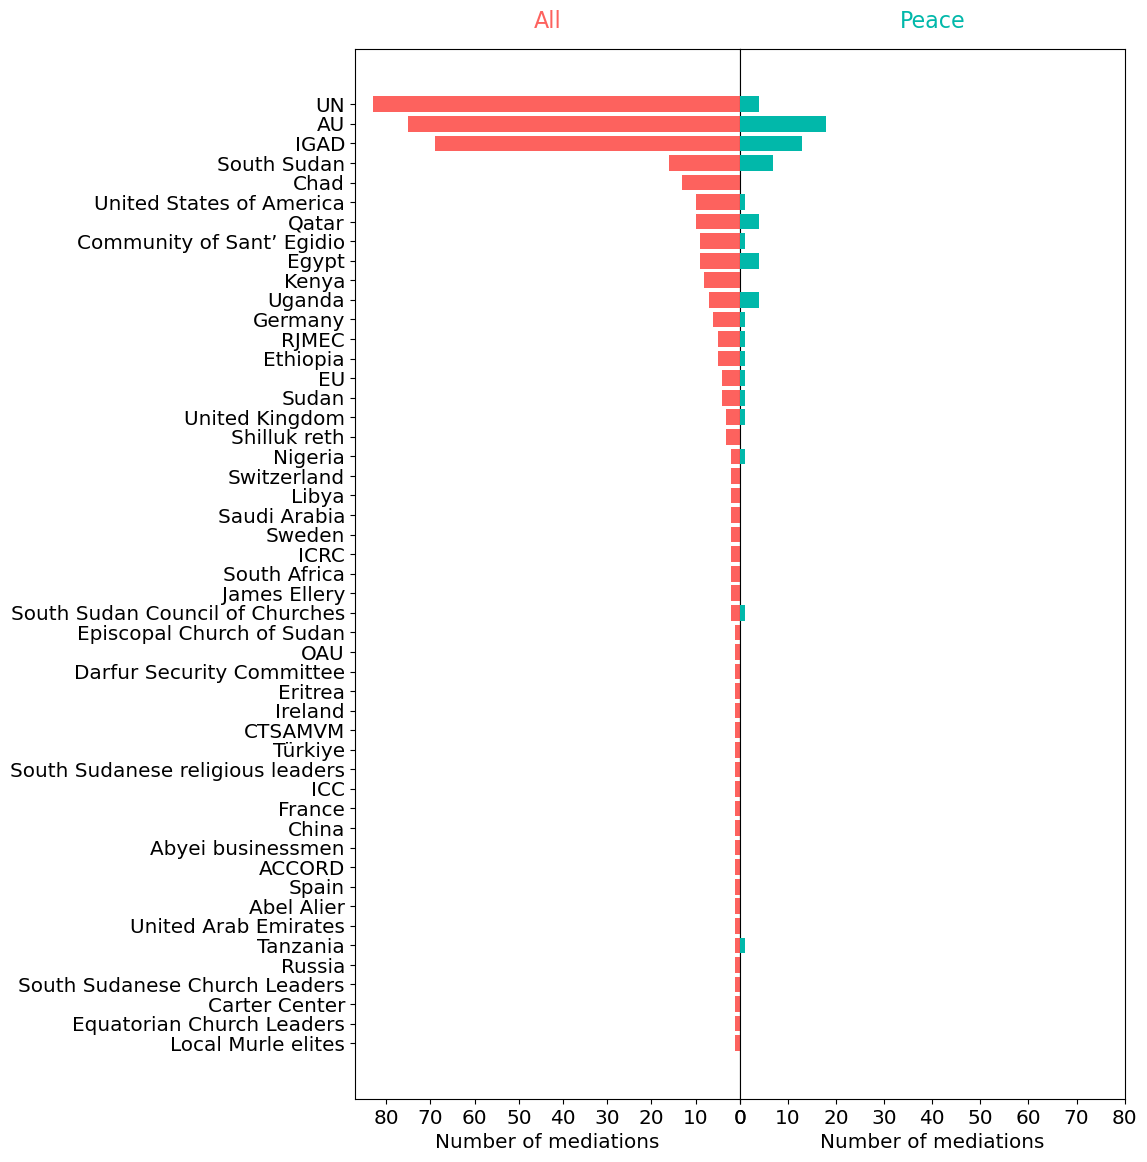

In [5]:
# Collect lead actors from all edges
indices = np.where(data_dict['matrix'] > 0)

lead_counts = {}

for i in range(0,len(indices[0])):
    mediation_index = indices[0][i]
    actor_index = indices[1][i]
    actor_id = data_dict['actor_vertices'][actor_index]
    edge_weight = data_dict['matrix'][mediation_index,actor_index]
    edge_dict = recover_edge_dict(edge_weight,len(get_empty_edge_dict()))
    if int(edge_dict['is_lead']) == 1:
        if actor_id in lead_counts:
            lead_counts[actor_id][0] += 1
        else:
            lead_counts[actor_id] = [1,0]
    
# Collect lead actors from peace matrix
indices = np.where(peace_dict['matrix'] > 0)

for i in range(0,len(indices[0])):
    mediation_index = indices[0][i]
    actor_index = indices[1][i]
    actor_id = peace_dict['actor_vertices'][actor_index]
    edge_weight = peace_dict['matrix'][mediation_index,actor_index]
    edge_dict = recover_edge_dict(edge_weight,len(get_empty_edge_dict()))
    if int(edge_dict['is_lead']) == 1:
        if actor_id in lead_counts:
            lead_counts[actor_id][1] += 1
        else:
            lead_counts[actor_id] = [0,1]

plt.plot([v[0] for _,v in lead_counts.items()])
plt.plot([v[1] for _,v in lead_counts.items()])
plt.show()

print(stats.pearsonr([v[0] for _,v in lead_counts.items()],[v[1] for _,v in lead_counts.items()]))

sorted_leads = sorted(lead_counts.items(),key=lambda kv:kv[1][0])

plot_birectional([(t[0],t[1][0]) for t in sorted_leads],[(t[0],t[1][1]) for t in sorted_leads],\
                 ['All','Peace'],max_x=0,labelled=True,file='')
